In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/Documents/Code/udgm_learning`


In [2]:
using Revise
import Distributions
import LinearAlgebra: dot

import MLDatasets
using MLUtils
using Flux.Losses

using Images
using StatsBase

using ProgressMeter

In [3]:
includet("hopfield.jl")

__!! Definitions and training code is found in `hopfield.jl` !!__

# Train and recall on MNIST

## Load MNIST samples

In [4]:
mnist = round.(Int, MLDatasets.MNIST(:train).features[:,:,1:1000]);

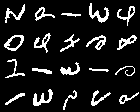

In [5]:
mosaicview(Gray.(mnist[:,:,1:20]), nrow=4)

In [229]:
r, c = size(mnist)[1:2]
nsamples = floor(Int, 0.005*r*c)

## MNIST patterns
pattern = Int.(mnist[:,:,1:nsamples]);
vpattern = pattern_to_vector(pattern) # pattern as vector rather than matrix
## random patterns
# pattern = rand([0,1], r, c, nsamples)

## Add noise to pattern / obscure parts
pattern_masked = copy(pattern)
# pattern_masked[:,1:1*size(pattern_masked,2)÷2,:] .= 0
pattern_masked .+= rand(Distributions.Bernoulli(0.05), size(pattern_masked))
# pattern_masked[rand(1:r*c, size(pattern,3)).+(1:r*c:length(pattern))] .+= 1
pattern_masked .%= 2;
vpattern_masked = pattern_to_vector(pattern);

## Hebbian learning

In a heuristic approach, the weights are set to $W_{ij} = \sum_n x^{(n)}_ix^{(n)}_j$ where the sum is over all patterns to be stored.

In [240]:
H_binary = BinaryHopfieldNetwork(r*c)
train_hebbe!(H_binary, vpattern)

@time recalls = round.(Int, recall!(H_binary, vpattern_masked; maxiter=100).+1).÷2
# recalls = recall!(H, pattern_to_vector(pattern_masked); maxiter=100)
recalls = reshape(recalls, r, c, size(recalls, 2));

  0.012051 seconds (35 allocations: 81.328 KiB)


__Hebbe learning performs poorly on correlated patterns__

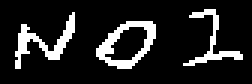

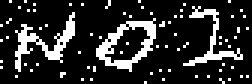

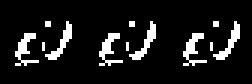

In [241]:
display(mosaicview(Gray.(pattern),nrow=1))
display(mosaicview(Gray.(pattern_masked),nrow=1))
display(mosaicview(Gray.(recalls),nrow=1))

## Maximum Likelihood

Learn the weights of the network by minimizing the _binary cross entropy_ between predictions and examples.

A random amount of noise is added to the examples at every epoch of the optimation in order to teach the network to denoise.

A continuous version of the Hopfield net with state vector $x_i\in [-1,1]\subset R$ is used.

__Training may take ~10 minutes.__

In [ ]:
Hmap = ContinuousHopfieldNetwork(r*c)

In [168]:
@time train_map!(Hmap, vpattern; J=0.0/(r*c), pretrain=false, bias=false, p_noise=0.01, epochs=100)

(epoch, loss) = (10, 3.9055809750235576e-7)
(epoch, loss) = (20, 2.3176423459628738e-7)
(epoch, loss) = (30, 3.276376202628072e-7)
(epoch, loss) = (40, 4.0734046775240374e-7)
(epoch, loss) = (50, 2.5230304896909256e-7)
(epoch, loss) = (60, 2.9292714911084066e-7)
(epoch, loss) = (70, 1.542120305998572e-7)
(epoch, loss) = (80, 4.13907792834156e-7)
(epoch, loss) = (90, 4.3401195277392436e-7)
(epoch, loss) = (100, 1.2088363280281018e-7)
 48.935874 seconds (182.25 k allocations: 2.089 GiB, 0.53% gc time)


ContinuousHopfieldNetwork([0.0 1.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0; … ; 1.0 1.0 … 0.0 1.0; 1.0 1.0 … 1.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [-0.9999997835663541, -0.9999997837114029, -0.9999997835404018, -0.9999997835454534, -0.9999997835311818, -0.9999997835360361, -0.9999997836403339, -0.9999997835148615, -0.9999997835910152, -0.9999997835338456  …  -0.9999997834008435, -0.9999997835507691, -0.9999997836065466, -0.9999997836100315, -0.9999997835035939, -0.9999997835014677, -0.999999783622596, -0.9999997836141762, -0.999999783543104, -0.9999997836615666])

In [245]:
@time recalls = round.(Int, recall(Hmap.W, Hmap.θ, vpattern_masked; maxiter=100)[2].+1).÷2
# recalls = recall!(H, pattern_to_vector(pattern_masked); maxiter=100)
recalls = reshape(recalls, r, c, size(recalls, 2));

  0.003598 seconds (27 allocations: 141.672 KiB)


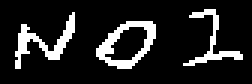

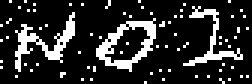

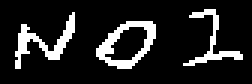

In [246]:
# @show converged
display(mosaicview(Gray.(pattern),nrow=1))
display(mosaicview(Gray.(pattern_masked),nrow=1))
display(mosaicview(Gray.(recalls),nrow=1))


__Much better :)__

# Training on random pattern

While Hebbian learning does not seem to work well for correlated patterns like MNIST digits, it performs well on random data.

Here we investigate how recall accuracy behaves as a function of the number of stored random patterns. Theory dicates that there is a phase transition at $L/N \sim 0.138$ where $L$ is number of patterns and $N$ their dimension.

## Setup

`r` is the linear dimension (28 for MNIST above) of our samples.

In [250]:
n_samples(r) = round.(Int, [0.01, 0.05, 0.08, 0.10, 0.12, 0.13, 0.14, 0.15, 0.16, 0.20, 0.4, 0.6].*r^2)

n_samples (generic function with 1 method)

## Training loop

In [247]:
import Random

In [248]:
Random.seed!(1234)

Random.TaskLocalRNG()

In [251]:
r = 16
H = ContinuousHopfieldNetwork(r^2)
@time lossconviters = map(repeat([r],outer=6)) do _r
    nsamples = n_samples(_r)
    loss = Vector{Vector{Float64}}()
    conv = Vector{Vector{Int}}()
    iters = Vector{Vector{Int}}()
    for n in nsamples
        lci = measure_recall_random(_r, n; H=H, p_noise=0.0,
            # loss=(p,r)->reshape(binarycrossentropy((r.+1)./2, (p.+1)./2, agg=x->mean(x, dims=1)), :),
            # loss=overlap,
            loss=(p,r)->reshape(hinge_loss(r,p, agg=x->mean(x, dims=1)), :),
            maxiter=2000, verbose=false)
        # @show typeof(lci)
        push!(loss, getindex(lci, 1))
        push!(conv, getindex(lci, 2))
        push!(iters, getindex(lci, 3))
    end
    (;loss, conv, iters)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 

 15.310978 seconds (3.45 M allocations: 3.924 GiB, 8.62% gc time, 12.64% compilation time)


In [16]:
using CairoMakie

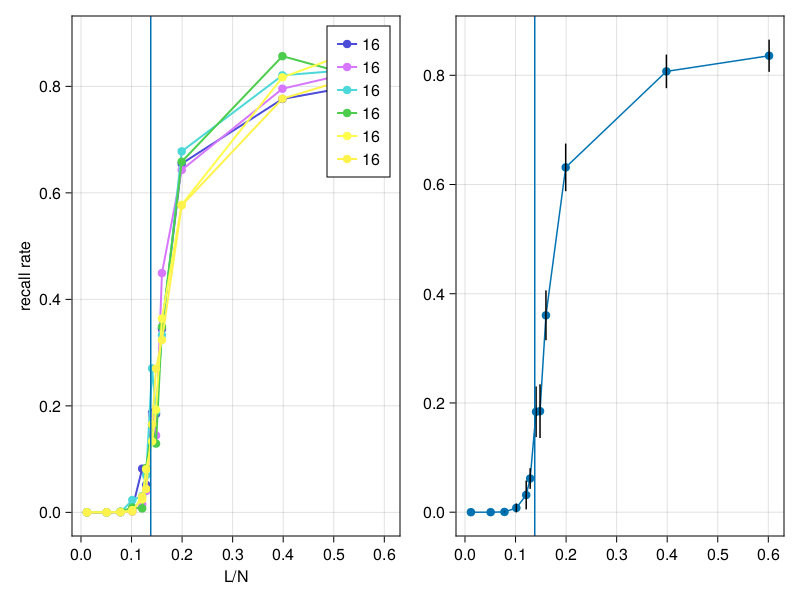

In [252]:
xrange = n_samples(r) ./ r^2
yseries = reduce(vcat, map(lossconviters) do x
    reshape(reduce(hcat, mean.(x[:loss])), 1, :)
end)
fig, ax, plt = series(xrange, yseries, marker=:circle, axis=(xlabel="L/N", ylabel="recall rate"), labels=["$r" for _ in axes(yseries,1)])
axislegend(ax)
vlines!(ax, 0.138)

means = reshape(mean(yseries, dims=1), :)
vars = reshape(var(yseries, dims=1), :)

scatterlines(fig[1,2], xrange, means)
errorbars!(xrange, means, sqrt.(vars))
vlines!(0.138)

fig
